<a href="https://colab.research.google.com/github/sakil0518/ConUHacksVII/blob/main/c433_Huron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C433 Huron Segmentation



Checking the platform, since we need a Linux or a Mac platform for Mask2Former to run.

# Install packages

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

1. Data Loading: Organizing images and masks as Detectron2 expects.
2. Augmentation: Using Albumentations to apply augmentations that are compatible with both images and masks.
3. Dataset Registration: Registering the custom dataset with Detectron2.

## 1.Load data

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
!pip install datasets
!pip install albumentations
!pip install dill

In [ ]:
# folder_path = "/content/drive/MyDrive/c433_project/Sliced_Images_2"

# # Get all file names and extract numbers
# file_numbers = set(int(filename.split('.')[0]) for filename in os.listdir(folder_path) if filename.split('.')[0].isdigit())

# # Expected range from 0 to 17374
# all_numbers = set(range(17374 + 1))

# # Find the missing numbers by checking the difference
# missing_numbers = sorted(all_numbers - file_numbers)

# print("Missing numbers:", missing_numbers)

### Create Dataset
- split the dataset into train, val and test
- 0.7 : 0.3

In [ ]:
from datasets import Dataset, DatasetDict, Image
from glob import glob
import os
import random
import torch

# Set paths for images and masks
image_folder = "/content/drive/MyDrive/c433_project/Sliced_Images/"
mask_folder = "/content/drive/MyDrive/c433_project/Sliced_masks/"

# Get list of image and mask file paths
image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder)])

# Ensure the image and mask lists are aligned
assert len(image_paths) == len(mask_paths), "Image and mask lists must have the same length"
for img, mask in zip(image_paths, mask_paths):
    assert os.path.basename(img).split('.')[0] == os.path.basename(mask).split('.')[0], "Images and masks are not aligned"

random.seed(42)

# Zip the image and mask paths together, shuffle, and then unzip
combined = list(zip(image_paths, mask_paths))
random.shuffle(combined)
image_paths_shuffled, mask_paths_shuffled = zip(*combined)

image_paths_shuffled = list(image_paths_shuffled)
mask_paths_shuffled = list(mask_paths_shuffled)
print(len(image_paths_shuffled))
print(len(mask_paths_shuffled))



train_size = int(len(image_paths_shuffled) * 0.7)
# image_paths_train = image_paths_shuffled[:train_size]
image_paths_train = image_paths_shuffled[:1000]
image_paths_test = image_paths_shuffled[1000:1300]

val_size = int(len(image_paths_train) * 0.3)
image_paths_validation = image_paths_train[:val_size]
image_paths_train = image_paths_train[val_size:]


# mask_paths_train = mask_paths_shuffled[:train_size]
mask_paths_train = mask_paths_shuffled[:1000]

mask_paths_test = mask_paths_shuffled[1000:1300]

mask_paths_validation = mask_paths_train[:val_size]
mask_paths_train = mask_paths_train[val_size:]


def create_dataset(image_paths, mask_paths):
    dataset = Dataset.from_dict({"pixel_values": image_paths, "label": mask_paths})
    dataset = dataset.cast_column("pixel_values", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

# Create Dataset objects for each split
train_dataset = create_dataset(image_paths_train, mask_paths_train)
validation_dataset = create_dataset(image_paths_validation, mask_paths_validation)
test_dataset = create_dataset(image_paths_test, mask_paths_test)

# Create the DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

17347
17347


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 2800
    })
    validation: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1200
    })
})

-  Define labels for tissue and non-tissue (background). This is for mask images

In [ ]:
import json
# Define labels for tissue and non-tissue (background)
id2label = {
    0: "non-tissue",  # Background
    1: "tissue"       # Tissue
}

# Save the updated id2label mapping to a JSON file
# with open('/content/drive/MyDrive/c433_project/id2label.json', 'w') as fp:
#     json.dump(id2label, fp)


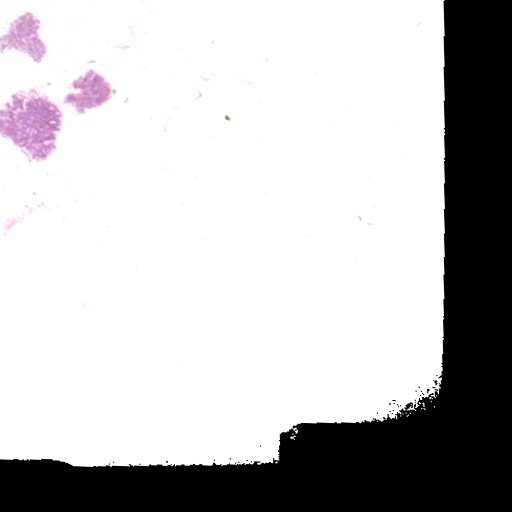

In [ ]:
train_ds = dataset["train"]
test_ds = dataset["test"]
example = train_ds[2]
image = example['pixel_values']
image

To account for the red marker in the segmentation mask, let’s modify the conversion function. The marker can often be identified by a specific range of red values, so we’ll set a color range to differentiate between the marker and tissue areas.

Here’s an updated version of the conversion function to include the marker:

- maps mask images rgb into label

In [ ]:
import numpy as np
import json

def rgb_to_class_labels(segmentation_map, tolerance=5):
    # Initialize the label map with all zeros (default to non-tissue)
    label_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1]), dtype=np.uint8)

    # Define RGB value for tissue
    tissue_green = np.array([0, 255, 0])

    # Map tissue (1) based on tolerance, everything else stays 0 (non-tissue)
    label_map[np.all(np.abs(segmentation_map - tissue_green) <= tolerance, axis=-1)] = 1  # Tissue

    return label_map


- enhance contrast of preview images for faint tissues

In [ ]:
import cv2
import numpy as np

def enhance_contrast(image):
    # Convert to LAB color space for better contrast enhancement
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge the channels back
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_image

# Use the function in your dataset class
# original_image = enhance_contrast(original_image)


In [ ]:
# segmentation_map = np.array(example['label'])
# segmentation_map

In [ ]:
# np.unique(segmentation_map)

In [ ]:
# label_map = rgb_to_class_labels(segmentation_map)
# print("Unique values in label_map:", np.unique(label_map))
# print("Classes in this image:", [id2label[label] for label in np.unique(label_map)])

# tissue_mask = (segmentation_map == [0, 255, 0]).all(axis=-1)
# print("Number of tissue pixels:", np.sum(tissue_mask))

# print("Sample pixel values in segmentation_map:", segmentation_map[segmentation_map == [0, 255, 0]])

# tissue_green_pixels = segmentation_map[np.all(segmentation_map == [0, 255, 0], axis=-1)]
# print("Sample tissue-green pixel values:", tissue_green_pixels)


In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(label_map, cmap="gray")
# plt.colorbar()
# plt.title("Label Map (0: non-tissue, 1: Tissue)")
# plt.show()


In [ ]:
# segmentation_map = np.array(example['label'])
# Apply contrast enhancement before segmentation mapping
# enhanced_segmentation_map = enhance_contrast(segmentation_map)
# segmentation_map = rgb_to_class_labels(segmentation_map)
# segmentation_map = kmeans_segmentation(segmentation_map)

In [ ]:
# np.unique(segmentation_map)

we want to know the actual class names.

In [ ]:
# # Path to id2label.json in Google Drive
# id2label_path = '/content/drive/MyDrive/c433_project/id2label.json'

# # Load id2label mapping
# with open(id2label_path, 'r') as fp:
#     id2label = json.load(fp)
# id2label = {int(k): v for k, v in id2label.items()}

# # Print id2label mapping for verification
# print("ID to Label Mapping:", id2label)

# # Assuming segmentation_map is already generated
# # Get unique labels in the segmentation map and convert them to their names
# labels = [id2label[label] for label in np.unique(segmentation_map)]
# print("Class Names in Segmentation Map:", labels)

Let's visualize it:

In [ ]:
def color_palette():
    """Custom color palette mapping each class to RGB values."""
    return [
        [0, 0, 0],        # Non-tissue (background)
        [0, 255, 0]       # Tissue (green)
    ]

palette = color_palette()


In [ ]:
# np.array(image).shape

In [ ]:
# import matplotlib.pyplot as plt

# # Example segmentation map with labels 0 (background) and 1 (tissue)
# # Adjust this part to your actual segmentation map if needed

# # Initialize the color map with zeros
# color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)

# # Apply the color palette to each class in the segmentation map
# for label, color in enumerate(palette):
#     color_segmentation_map[segmentation_map  == label, :] = color

# # Overlay the color map with the original image
# img = np.array(image) * 0.3 + color_segmentation_map * 0.7
# img = img.astype(np.uint8)

# # Display the overlaid image
# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.axis("off")
# plt.show()


## 2.Create PyTorch Dataset

In [ ]:
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from PIL import Image

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset with preprocessing and original data for mIoU computation."""

    def __init__(self, dataset, transform=None):
        """
        Args:
            dataset: A dataset containing images and corresponding segmentation maps.
            transform (callable, optional): Transformations to apply to the image and segmentation map.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load the original image and segmentation map from the dataset
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # Ensure the image is in (H, W, C) format
        # if original_image.ndim == 3 and original_image.shape[0] == 3:
        #     original_image = original_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        # elif original_image.ndim == 2:
        #     original_image = np.stack([original_image] * 3, axis=-1)  # Convert grayscale to (H, W, 3)

        # Convert segmentation map to class labels
        original_segmentation_map = rgb_to_class_labels(original_segmentation_map)

        # Apply transformations if defined
        if self.transform:
            transformed = self.transform(image=original_image, mask=original_segmentation_map)
            image, segmentation_map = transformed['image'], transformed['mask']
        else:
            image, segmentation_map = original_image, original_segmentation_map

        original_image = enhance_contrast(original_image)

        # Convert image to (C, H, W) format for PyTorch compatibility
        image = image.transpose(2, 0, 1)

        # Return the preprocessed image and segmentation map, along with the original versions
        return image, segmentation_map, original_image, original_segmentation_map


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
ADE_MEAN = [0.8788, 0.8479, 0.8733]
ADE_STD = [0.2519, 0.2699, 0.2530]

# Training transformations
train_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.3),
    A.HorizontalFlip(p=0.5),                    # Random horizontal flip
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),    # Normalize using mean and std

])

# Test transformations
test_transform = A.Compose([
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),    # Only normalization for test data
])

train_dataset = ImageSegmentationDataset(dataset['train'], transform=train_transform)
validation_dataset = ImageSegmentationDataset(dataset['validation'], transform=test_transform)
test_dataset = ImageSegmentationDataset(dataset['test'], transform=test_transform)

In [ ]:
# train_dataset = ImageSegmentationDataset(dataset['train'])
# validation_dataset = ImageSegmentationDataset(dataset['validation'])
# test_dataset = ImageSegmentationDataset(dataset['test'])

## 3.Create Pytorch Dataloaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [ ]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = [img.transpose(1, 2, 0) for img in inputs[0]]  # Convert to (H, W, C) format
    segmentation_maps = inputs[1]  # Keep segmentation maps in (H, W) format

    # Check for empty masks and set to all-zero masks if necessary
    for i, seg_map in enumerate(segmentation_maps):
        if np.unique(seg_map).size == 0:
            segmentation_maps[i] = np.zeros_like(seg_map, dtype=np.uint8)  # Assign background-only mask


    # Debug: Print shapes and types to check consistency
    # print("Image shapes:", [img.shape for img in images])
    # print("Segmentation map shapes:", [seg.shape for seg in segmentation_maps])

    # Preprocess images and segmentation maps
    try:
        batch = preprocessor(
            images,
            segmentation_maps=segmentation_maps,
            return_tensors="pt",
        )
    except Exception as e:
        print("Error during preprocessing:", e)
        return None

    batch["original_images"] = inputs[2]  # Original images
    batch["original_segmentation_maps"] = inputs[3]  # Original segmentation maps

    return batch


batch_size = 4
epochs = 5
lr = 0.001


# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### Normalization

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [ ]:
# import torch

# num_pixels = 0
# channel_sum = torch.zeros(3)
# channel_squared_sum = torch.zeros(3)

# # Loop over the dataset to calculate the sum and sum of squares for each channel
# for batch in train_dataloader:  # Iterate through batches
#     images = batch['pixel_values']  # Access images from the 'pixel_values' key

#     # Normalize images to [0, 1] range
#     images = images / 255.0

#     # Flatten the images to (N, C, H * W) so we can calculate statistics across all pixels in each batch
#     images = images.view(images.size(0), images.size(1), -1)
#     num_pixels += images.size(0) * images.size(2)  # Total number of pixels per channel

#     # Sum and squared sum across batches
#     channel_sum += images.sum(dim=[0, 2])
#     channel_squared_sum += (images ** 2).sum(dim=[0, 2])

In [ ]:
# Calculate mean and std
# mean = channel_sum / num_pixels
# std = torch.sqrt((channel_squared_sum / num_pixels) - (mean ** 2))

# print("Mean:", mean)
# print("Std:", std)

In [ ]:
# Mean and standard deviation for normalization
# ADE_MEAN = mean.tolist()
# ADE_STD = std.tolist()



# Test the dataset
# image, segmentation_map, original_image, original_segmentation_map = train_dataset[10]
# print(image.shape)
# print(segmentation_map.shape)
# print(original_image.shape)
# print(original_segmentation_map.shape)

In [ ]:
# from PIL import Image
# # Unnormalize the image
# unnormalized_image = (image * np.array(ADE_MEAN)[:, None, None]) + np.array(ADE_STD)[:, None, None]
# unnormalized_image = (unnormalized_image * 255).clip(0, 255).astype(np.uint8)

# # Convert from (C, H, W) to (H, W, C) for visualization
# # unnormalized_image = np.transpose(unnormalized_image, (1, 2, 0))
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
# # Display the unnormalized image
# Image.fromarray(unnormalized_image)

In [ ]:
# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=2)
# validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [ ]:
# import cv2
# # Test transform
# transform = A.Compose([A.HorizontalFlip(p=1)])

# # Dummy image in (H, W, C)
# dummy_image = np.random.randint(0, 255, (512, 512, 3), dtype=np.uint8)

# try:
#     transformed = transform(image=dummy_image)['image']
#     print("Transformation successful with shape:", transformed.shape)
# except Exception as e:
#     print("Error during transformation:", e)


## 4.Verify data

check whether the data you feed to the model actually makes sense.

In [ ]:
batch = next(iter(train_dataloader))
if batch is not None:
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            print(k,':', v.shape)
        else:
            print(k, ':',v[0].shape)
else:
    print("Batch is None")


pixel_values : torch.Size([8, 3, 512, 512])
pixel_mask : torch.Size([8, 512, 512])
mask_labels : torch.Size([1, 512, 512])
class_labels : torch.Size([1])
original_images : (512, 512, 3)
original_segmentation_maps : (512, 512)


In [ ]:
pixel_values = batch["pixel_values"][1].numpy()
pixel_values.shape

(3, 512, 512)

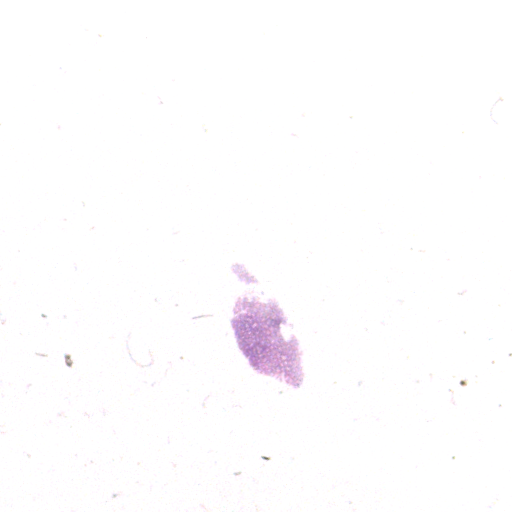

In [ ]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
# mask = batch["mask_labels"][0].cpu().numpy()
# print("Unique values in mask_labels:", np.unique(mask))

In [ ]:
# # verify class labels
# labels = [id2label[label] for label in batch["class_labels"][5].tolist()]
# print(labels)

In [ ]:
# # verify mask labels
# batch["mask_labels"][0].shape

In [ ]:
# # Check the class labels for a specific batch item
# labels = [id2label[label] for label in batch["class_labels"][0].tolist()]  # Check for the first item
# print("Class labels in batch item:", labels)

# # Check if both classes are represented in mask_labels
# for i, mask in enumerate(batch["mask_labels"]):
#     unique_values = np.unique(mask.cpu().numpy())
#     print(f"Unique values in mask_labels[{i}]:", unique_values)

In [ ]:
# def visualize_mask(labels, label_name):
#   print("Label:", label_name)
#   idx = labels.index(label_name)

#   visual_mask = (batch["mask_labels"][5][idx].bool().numpy() * 255).astype(np.uint8)
#   return Image.fromarray(visual_mask)


In [ ]:
# visualize_mask(labels, "tissue")

# Model

## 1.Define model

In [ ]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model
# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          # id2label=id2label,
                                                          # ignore_mismatched_sizes=True)

model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# outputs = model(batch["pixel_values"],
#                 class_labels=batch["class_labels"],
#                 mask_labels=batch["mask_labels"])

In [ ]:
# outputs.loss

## 2.Train model
- train model and validate




In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# !pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
import torch
from tqdm.auto import tqdm

accumulation_steps = 4  # Number of steps to accumulate gradients
effective_batch_size = batch_size * accumulation_steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device("cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses = []


for epoch in range(1,11):
  print("Epoch:", epoch)
  model.train()

  running_loss = 0.0
  num_samples = 0

  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()
      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      # Perform optimizer step after `accumulation_steps`
      if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_dataloader):
          optimizer.step()
          optimizer.zero_grad()

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      # optimizer.step()
    # Calculate and store the average loss for the epoch
  avg_loss = running_loss / len(train_dataloader)
  train_losses.append(avg_loss)
  print(f"Epoch {epoch} Average Loss: {avg_loss}")

  model.eval()
  for idx, batch in enumerate(tqdm(validation_dataloader)):
    # if idx > 5:
    #   break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)


  # train_losses.append(running_loss)


  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

Epoch: 1


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 12.304800033569336
Loss: 6.966181877816077
Epoch 1 Average Loss: 26.094694164821078


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Mean IoU: 1.0
Epoch: 2


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 6.382551193237305
Loss: 5.82688029449765
Epoch 2 Average Loss: 22.470255546569824


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 0.4999905015582701
Epoch: 3


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 3.618351936340332
Loss: 5.039524598581957
Epoch 3 Average Loss: 20.56439126082829


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0
Epoch: 4


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 9.015680313110352
Loss: 5.048091294741867
Epoch 4 Average Loss: 19.839691429138185


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0
Epoch: 5


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 2.3834662437438965
Loss: 4.6462928953737315
Epoch 5 Average Loss: 19.088800852639334


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0
Epoch: 6


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 4.628071308135986
Loss: 4.6826789756812675
Epoch 6 Average Loss: 18.43321955544608


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0
Epoch: 7


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 3.1059858798980713
Loss: 4.836886531055564
Epoch 7 Average Loss: 19.522521888187953


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0
Epoch: 8


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 3.8594272136688232
Loss: 4.77512782280988
Epoch 8 Average Loss: 18.465273952484132


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 0.49999718425640416
Epoch: 9


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 2.431894302368164
Loss: 4.428486690662875
Epoch 9 Average Loss: 18.856500974382673


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0
Epoch: 10


  0%|          | 0/175 [00:00<?, ?it/s]

Loss: 8.314865112304688
Loss: 4.61052147704776
Epoch 10 Average Loss: 17.50754964011056


  0%|          | 0/75 [00:00<?, ?it/s]

Mean IoU: 1.0


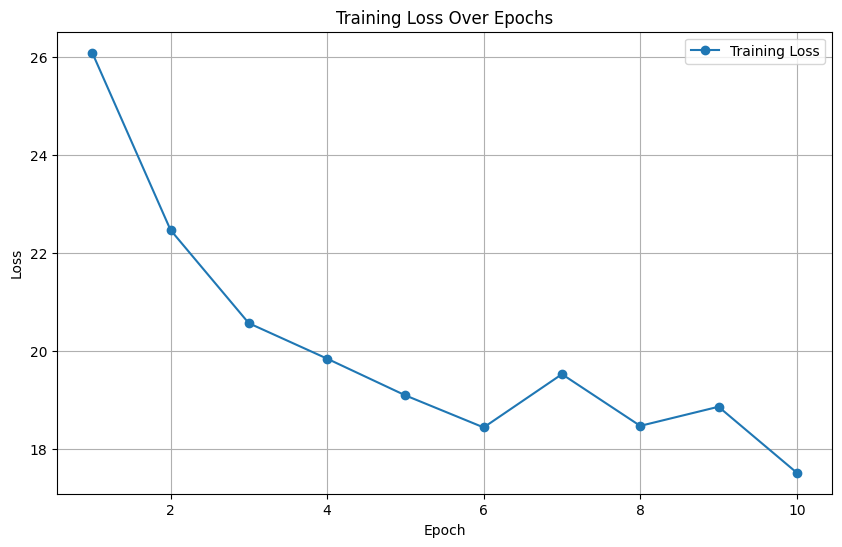

In [ ]:
from matplotlib import pyplot as plt

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Inference

In [ ]:
# let's take the first test batch
batch = next(iter(validation_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
mask_labels 4
class_labels 4
original_images 4
original_segmentation_maps 4


In [ ]:
# forward pass
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [ ]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

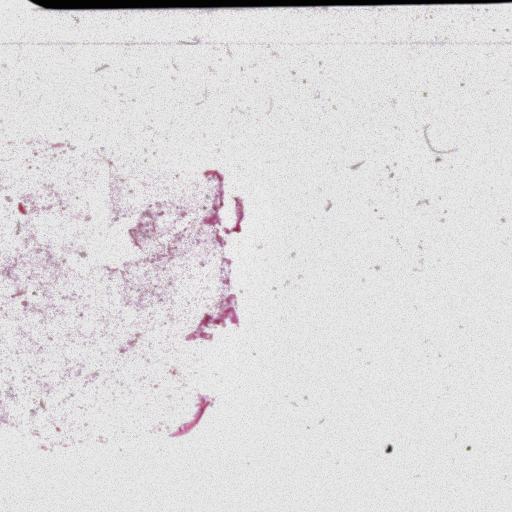

In [ ]:
from PIL import Image

image = batch["original_images"][0]
Image.fromarray(image)

- result

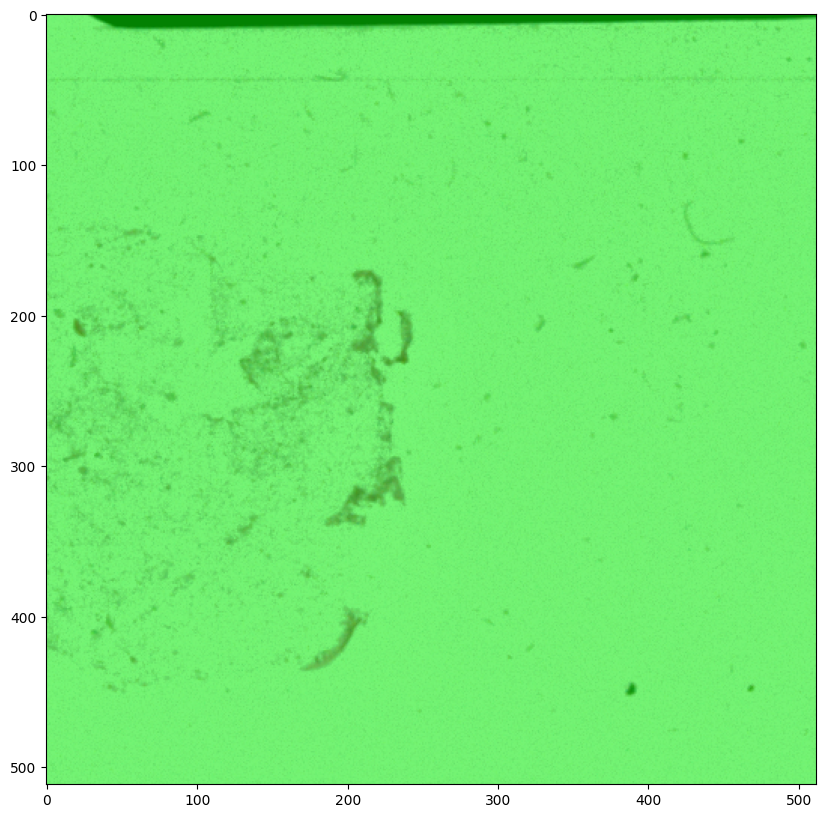

In [ ]:
import matplotlib.pyplot as plt
# import numpy as np

# image = image.numpy().transpose(1, 2, 0)

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

- ground truth

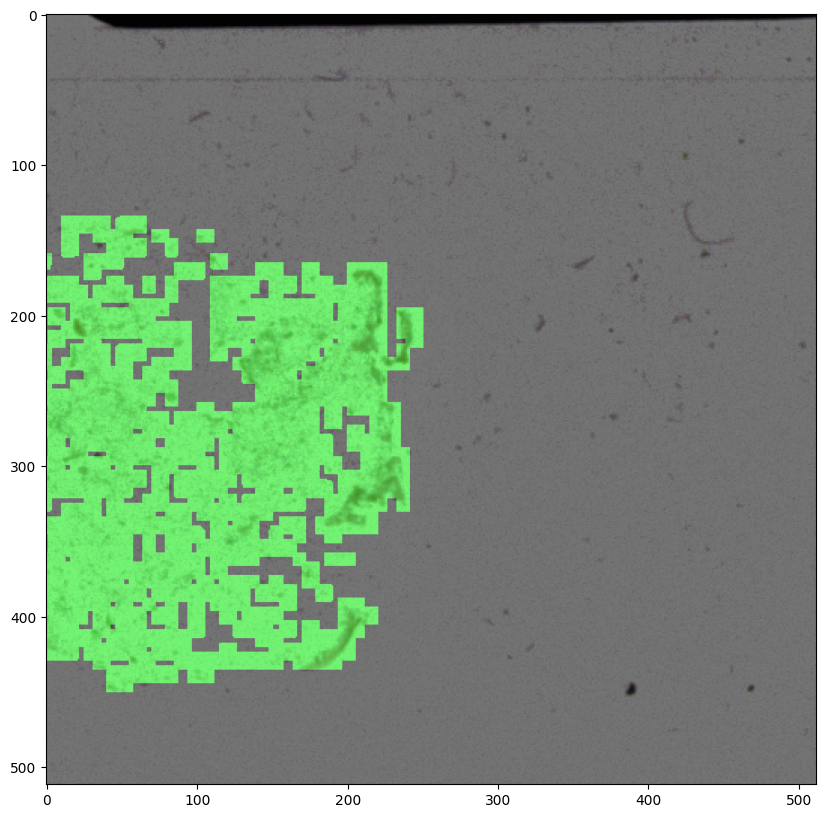

In [ ]:
segmentation_map = batch["original_segmentation_maps"][0]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()


### Training Configuration
- fine-tune Mask2Former on the custom dataset.